In [1]:
import torch
import torchvision
import torch.nn as nn
import torchgeometry as tgm
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import torch.nn.functional as F
import numpy as np

In [2]:
import torchvision

In [4]:
def show_image(inp, ax=None):
    inp = inp / torch.max(inp.view(3, -1), dim=-1).values.view(3, 1, 1)
    inp = torchvision.transforms.ToPILImage()(inp)
    if ax is None:
        plt.imshow(inp) #[0,...])
        plt.show()
    else:
        ax.imshow(inp)


In [17]:
from torchvision import transforms

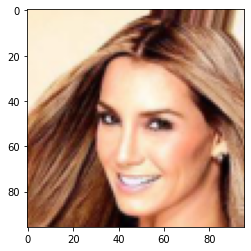

In [187]:
def transform(inp):
    main_transform = transforms.Compose(
        [
            transforms.Resize((64, 64)),
            transforms.ToTensor()],
    )
    inp = main_transform(inp)
    inp = inp + 1e-4
    inp = inp / torch.sum(torch.abs(inp))
    return inp

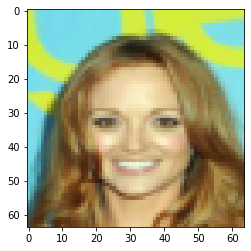

In [188]:
ds = torchvision.datasets.CelebA("/data/theory/robustopt/datasets/celeba", split='train', transform=transform, target_type="landmarks")
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)
for x, y in dl:
    break
show_image(x[0])

In [182]:
landmark = y[0]

In [198]:
landmarks_labels = ["left eye", "right eye", "nose", "left mouth", "right mouth"]
H = 218
W = 178
out_size = 64
landmark_mask = torch.zeros(len(landmarks_labels), out_size, out_size)
for i, idx in enumerate(np.arange(0, len(landmarks_labels)*2, 2)):
    x_coord, y_coord = landmark[idx+1], landmark[idx]
    x_coord = torch.round(x_coord/H*out_size).int().item()
    y_coord = torch.round(y_coord/W*out_size).int().item()
    landmark_mask[i, x_coord, y_coord] = 1

0 0 1
1 2 3
2 4 5
3 6 7
4 8 9


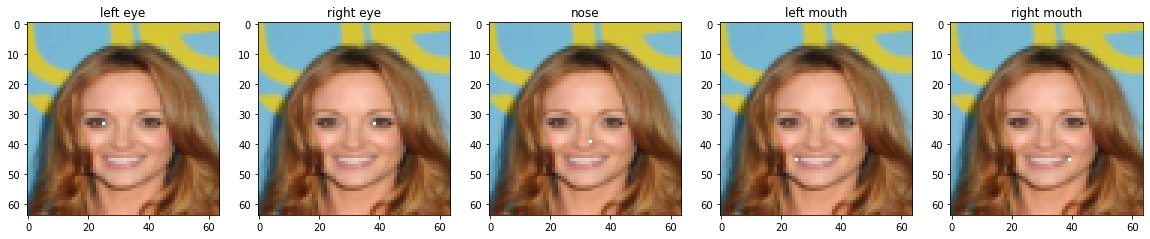

In [204]:
img = x[0]
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
base_color = torch.max(img.view(3, -1), dim=-1)[0][0]
for i in range(5):
    img = x[0].clone()
    img[:, landmark_mask[i] > 0] = base_color
    show_image(img, ax[i])
    ax[i].set_title(landmarks_labels[i])
plt.show()

In [227]:

class ConvolutionalWasserstein2D(nn.Module):
    def __init__(self, nin, s, gamma):
        super().__init__()
        self.a = torch.ones(1, nin, s, s) #/(s*s)
        self.s = s
        self.nin = nin
        self.gamma = gamma
        
        g_s = s
        if s % 2 == 0:
            g_s = s+1
        self.H = tgm.image.GaussianBlur((g_s, g_s), (gamma, gamma))
        
        
    def sinkhorn(self, mu_0, mu_1, iters, return_wv=False):
        w = torch.ones(*mu_0.shape)
        v = torch.ones(*mu_0.shape)
        for i in range(iters):
            v = mu_0 /(self.H(self.a*w))
            w = mu_1 /(self.H(self.a*v))
        if return_wv:
            return w, v
        out = mu_0 * torch.log(v) + mu_1 * torch.log(w)
        out = torch.flatten(out, 2, 3).unsqueeze(3)
        a = torch.flatten(out, 2, 3).unsqueeze(2)
        out = (a @ out).squeeze(2).squeeze(2)
        return self.gamma * out
    
    def compute_entropy(self, p):
        # p is (arbitrary batch dim) x nin x H x W
        # returns vector of size (arbitrary batch dim) x nin, or nin, of the separate entropies
        z_locs = (p <= 0)
        if len(p.shape) == 4:
            a_reshaped = self.a
        elif len(p.shape) == 3:
            a_reshaped = self.a[0, ...]
        else:
            a_reshaped = self.a[0, 0, ...]
        prod = a_reshaped * p * torch.log(p) 
        prod[z_locs] = 0
        return -1*torch.sum(prod, dim=[-1, -2])
    
    def entropic_sharpening(self, mu, H0):
        # mu is C x H x W
        # H0 is C 
        C, H, W = mu.shape
        
        # Doing this unbatched in C for now
        betas = torch.ones(C)
        for i in range(C):
            if self.compute_entropy(mu[i,...]) + torch.sum(mu[i, ...]*self.a[0, i, ...]) > H0[i] + 1:
                def f(beta):
                    mu_to_beta = torch.pow(mu[i,...], torch.tensor(beta))
                    return torch.sum(self.a[0, i, ...]*mu_to_beta) + self.compute_entropy(mu_to_beta) - (1 + H0[i])
                xx = fsolve(f, x0=[1]) # Does not include positivity constraint, not ideal.
                if xx[0] >= 0:
                    betas[i] = xx[0]
        sharpened = torch.pow(mu, betas.view(C, 1, 1))
        return sharpened
    
    def wass_barycenter(self, mu_s, alphas, iters, entropic_args=None): # NOT BATCHED
        # mu_s is K x C x H x W
        # alphas is K
        # M is the number of mu_s
        # entropic_args['factor'] changes the level of sharpening by scaling the maximum entropy
        # otherwise, setting entropic_args as None means to not do entropic sharpening
        K, C, H, W = mu_s.shape
        
        if entropic_args is not None:
            H0 = torch.max(self.compute_entropy(mu_s), dim=0).values
            H0 = entropic_args['factor']*H0 
        
        v = torch.ones_like(mu_s)
        w = torch.ones_like(mu_s)
        for j in range(iters):
            w = mu_s / self.H(self.a * v)
            d = v * self.H(self.a * w)
            mu = torch.ones(C, H, W)
            for i in range(K):
                mu = mu * torch.pow(d[i], alphas[i])
            if entropic_args is not None:
                mu = self.entropic_sharpening(mu, H0)
            v = (v * mu.unsqueeze(0))/d
        return mu
    
    def wass_barycenter_obj(self, mu, mu_s, alphas):
        # mu_s is K x C x H x W
        # alphas is K
        # mu is C x H x W
        K, C, H, W = mu_s.shape
        
        mu_repped = mu.repeat(K, 1, 1, 1)
        W2dists = self.sinkhorn(mu_repped, mu_s, iters=10) # K x C
        objvals = W2dists * alphas.view(-1,1).repeat_interleave(repeats=C, dim=-1) # K x C
        return torch.sum(objvals, 0)
    

0


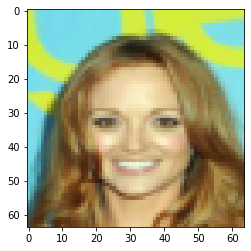

1


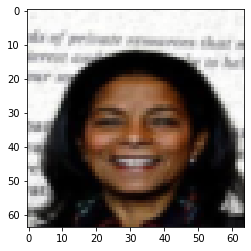

2


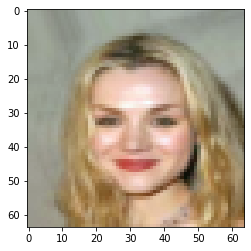

3


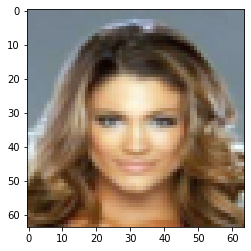

4


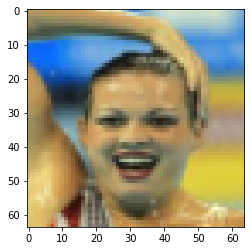

5


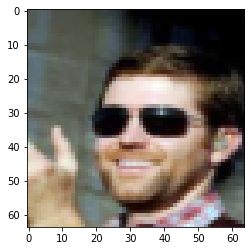

6


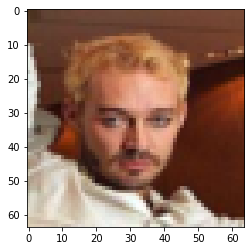

7


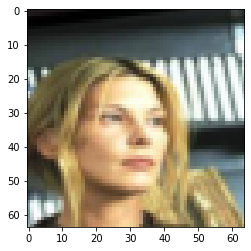

8


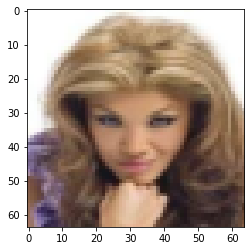

9


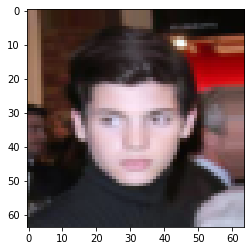

10


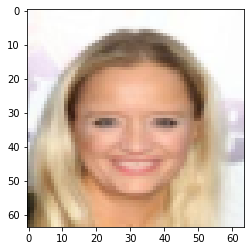

11


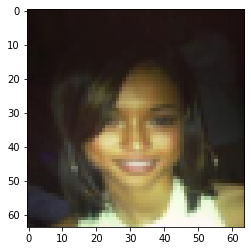

12


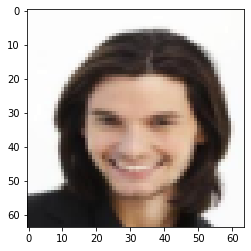

13


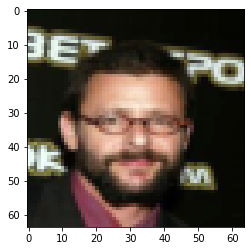

14


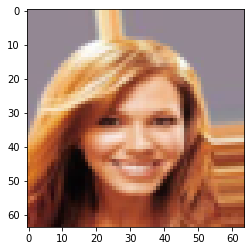

15


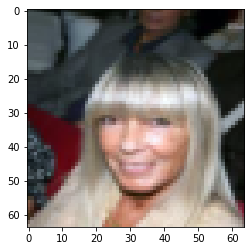

16


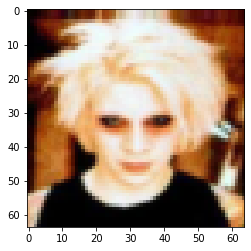

17


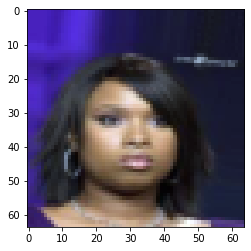

18


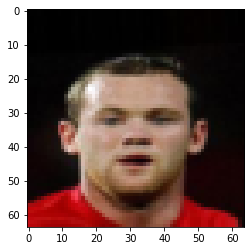

19


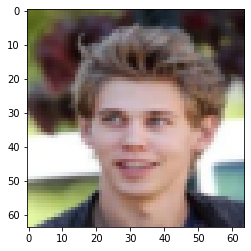

20


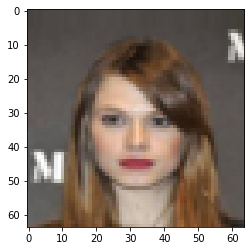

21


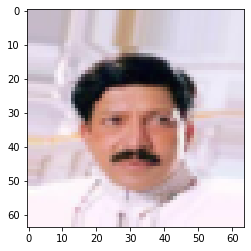

22


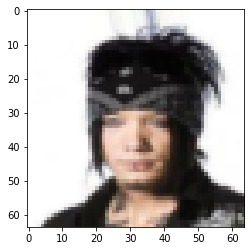

23


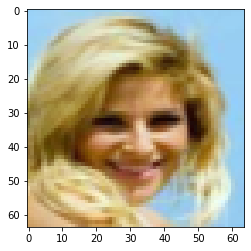

24


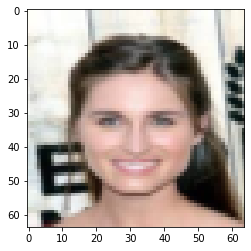

25


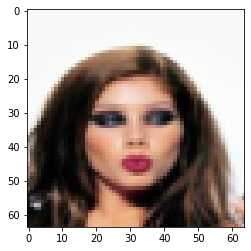

26


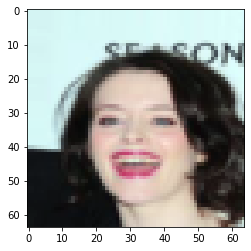

27


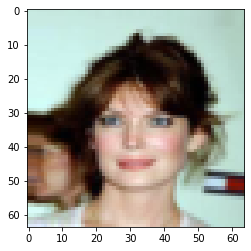

28


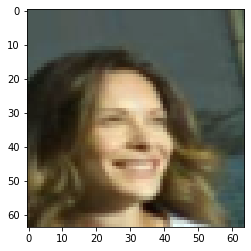

29


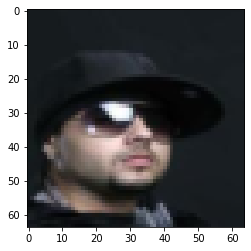

30


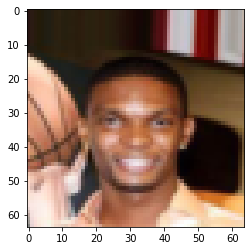

31


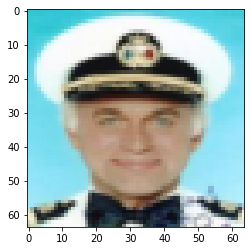

In [205]:
for b in range(32):
    print(b)
    show_image(x[b])

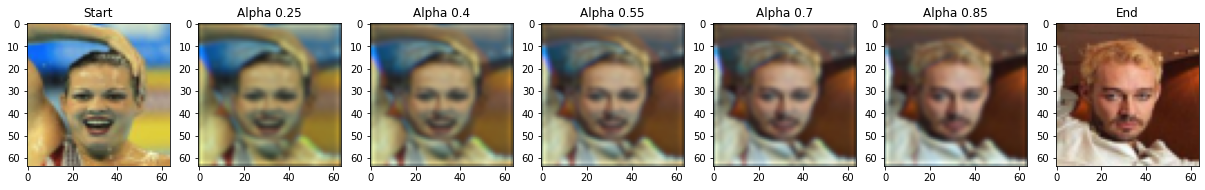

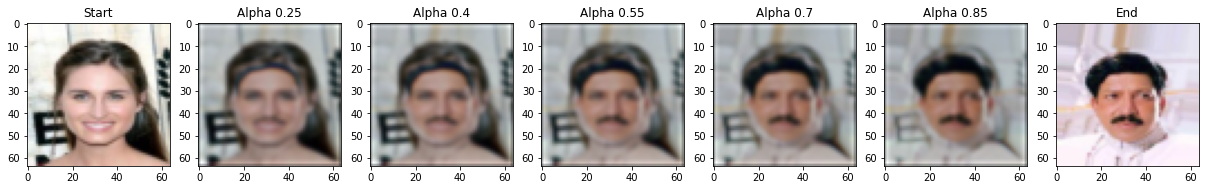

In [218]:
# example conv_was
for start_idx, target_idx in [(6,4), (21, 24)]:
    cw = ConvolutionalWasserstein2D(3, 64, gamma=1)
    pos_alphas = torch.arange(0.25, 1, 0.15)
    fig, ax = plt.subplots(1, len(pos_alphas)+2, figsize=((len(pos_alphas)+2)*3, 3))
    inp = x[[start_idx, target_idx]]
    show_image(inp[1,...], ax[0])
    ax[0].set_title(f"Start")
    show_image(inp[0, ...], ax[-1])
    ax[-1].set_title(f"End")

    with torch.no_grad():
        for i, alpha in enumerate(pos_alphas):
            alphas = torch.tensor([alpha, 1-alpha])
            fac = 0.3
            out = cw.wass_barycenter(inp, alphas, 10, entropic_args={'factor':fac})
            show_image(out, ax[i+1])
            ax[i+1].set_title(f"Alpha {alpha:.2}")
    plt.show()

In [214]:
f"{0.50332490:.4}"

'0.5033'

In [229]:
cw = ConvolutionalWasserstein2D(3, 64, gamma=1)

In [230]:
w, v = cw.sinkhorn(x[[0]], x[[1]], 10, return_wv=True)

In [232]:
v.shape

torch.Size([1, 3, 64, 64])

In [239]:
plan = v*cw.H(w)

In [237]:
v.shape

torch.Size([1, 3, 64, 64])

In [240]:
plan

tensor([[[[2.4248e-04, 2.2189e-04, 1.7501e-04,  ..., 2.2352e-04,
           2.2559e-04, 2.2717e-04],
          [2.4113e-04, 2.2439e-04, 1.7916e-04,  ..., 2.2373e-04,
           2.2473e-04, 2.2746e-04],
          [2.3954e-04, 2.2547e-04, 1.8342e-04,  ..., 2.0576e-04,
           2.0448e-04, 2.0037e-04],
          ...,
          [5.2650e-05, 6.8274e-05, 7.1915e-05,  ..., 3.9706e-05,
           4.6693e-05, 4.2304e-05],
          [5.7743e-05, 6.8946e-05, 7.4456e-05,  ..., 4.0276e-05,
           4.5325e-05, 4.7532e-05],
          [6.3233e-05, 7.4255e-05, 8.5414e-05,  ..., 3.6438e-05,
           4.3216e-05, 4.8173e-05]],

         [[1.8957e-04, 1.8680e-04, 1.7412e-04,  ..., 1.8540e-04,
           1.8660e-04, 1.8770e-04],
          [1.8791e-04, 1.8819e-04, 1.7658e-04,  ..., 1.8621e-04,
           1.8842e-04, 1.8752e-04],
          [1.8558e-04, 1.8787e-04, 1.7637e-04,  ..., 1.8577e-04,
           1.8698e-04, 1.8709e-04],
          ...,
          [8.4688e-05, 6.5980e-05, 4.3470e-05,  ..., 3.5704